## Let's test and see if the results improve after training on LOAF

In [9]:
import os
import sys
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import re
import cv2

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root_dir not in sys.path:
    sys.path.append(root_dir)

from DatasetLoader import DatasetLoader as dl
from save_info import save_model_info
import model_loss as ml
print(tf.__version__)

2.19.0


In [10]:
def get_models(dir):
    models = []
    names = []

    for model in os.listdir(dir):
        res = int(re.search(r"_r(\d+)", model).group(1))
        loss_fn = ml.construct_weighted_xent_fn((1, res // 8, res // 8, 2), object_weight=100)
        models.append(tf.keras.models.load_model(f"{dir}/{model}", compile=True, custom_objects={"weighted_xent": loss_fn}))
        names.append(model)
    return models, names

In [11]:
models, names = get_models("out_loaf")

### 1. Test FOMO trained on loaf

In [13]:
def read_img(path, res):
    img = cv2.imread(path)
    img = cv2.resize(img, (res, res))  # Resize to match model input
    img = img.astype(np.float32) / 255.0  # Normalize if needed
    img = np.expand_dims(img, axis=0)
    return img

In [14]:
img = read_img("../../dataset/hc/val/images/Meeting1_001081.jpg", 96)

for i in range(len(names)):
    if "a035_r96" in names[i]:
        m128 = models[i]

out = m128.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step


In [15]:
def plot_fomo_output(img, out, class_index=0, threshold=0.7, show_centers=True, heatmap_clip_threshold=0.3):

    # Remove batch dims
    if img.ndim == 4:
        img = img[0]
    if out.ndim == 4:
        out = out[0]

    # Convert logits to probabilities
    probs = 1 / (1 + np.exp(-out))  # sigmoid

    # Extract class-specific score map
    score_map = probs[..., class_index]

    heatmap_resized = cv2.resize(score_map, (img.shape[1], img.shape[0]))

    heatmap_masked = np.where(heatmap_resized >= heatmap_clip_threshold, heatmap_resized, 0)

    # Normalize for color map
    heatmap_norm = cv2.normalize(heatmap_masked, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    heatmap_color = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)

    # Prepare base image
    img_uint8 = (img * 255).astype(np.uint8) if img.dtype != np.uint8 else img
    blended = cv2.addWeighted(img_uint8, 0.6, heatmap_color, 0.4, 0)

    if show_centers:
        grid_h, grid_w = score_map.shape
        stride_x = img.shape[1] / grid_w
        stride_y = img.shape[0] / grid_h

        for y in range(grid_h):
            for x in range(grid_w):
                score = score_map[y, x]
                if score > threshold:
                    cx = int((x + 0.5) * stride_x)
                    cy = int((y + 0.5) * stride_y)
                    cv2.circle(blended, (cx, cy), 4, (0, 255, 0), -1)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('FOMO Output')
    plt.show()

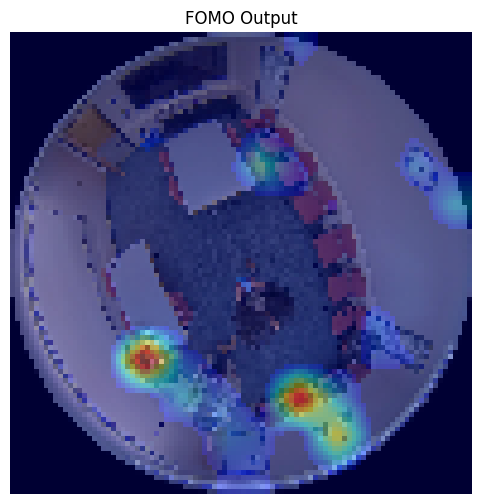

In [16]:
plot_fomo_output(img, out, class_index=0, threshold=0.4, show_centers=False, heatmap_clip_threshold=0.05)

### 2. Retrain models on HC dataset

In [17]:
from DatasetLoader import DatasetLoader as dl

datasets = []
train_ds = []

val_datasets = []
val_ds = []

counts = []
dl_loaders = []
sizes = [96, 128, 224]

for r in range(len(sizes)):
    dl_loaders.append(dl("RGB", "fomo-obj", sizes[r]))

    ds, c = dl_loaders[-1].get_dataset("train")
    datasets.append(ds.shuffle(c, reshuffle_each_iteration=True))
    counts.append(c)

    train_ds.append((datasets[-1]
        .shuffle(c)
        .map(lambda f, c: dl_loaders[-1].get_sample_fomo(f, c, train=True), 
                num_parallel_calls=tf.data.AUTOTUNE)
        .batch(32)
        .prefetch(tf.data.AUTOTUNE)))

    ds, c = dl_loaders[-1].get_dataset("test")
    val_datasets.append(ds)
    val_ds.append((val_datasets[-1]
        .map(lambda f, c: dl_loaders[-1].get_sample_fomo(f, c, train=False), 
                num_parallel_calls=tf.data.AUTOTUNE)
        .batch(32)
        .prefetch(tf.data.AUTOTUNE)))

In [20]:
model_to_ds = {"r96": [train_ds[0], val_ds[0]],
               "r128": [train_ds[1], val_ds[1]],
               "r224": [train_ds[2], val_ds[2]]}

loss = np.zeros(len(models))

for i in range(len(models)):
    for n, ds in model_to_ds.items():
        if n in names[i]:
            print(names[i])
            loss[i] = models[i].evaluate(ds[-1])
            break
loss

fomoloaf_a035_r128.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 315ms/step - loss: 0.1628
fomoloaf_a035_r224.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 798ms/step - loss: 0.0552
fomoloaf_a035_r96.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - loss: 0.2395
fomoloaf_a075_r128.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 583ms/step - loss: 0.1473
fomoloaf_a075_r224.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.0560
fomoloaf_a075_r96.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 449ms/step - loss: 0.2386


array([0.14380281, 0.04746788, 0.2116718 , 0.12755111, 0.04788134,
       0.21180743])

In [17]:
import re

NUM_EPOCHS = 10

lr_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1,
                                                 mode='auto', min_delta=0.0005, cooldown=0, min_lr=0)
checkpoint_filepath = []

for i in range(len(names)):
    a = re.search("a0\d*", names[i]).group(0)
    res = re.search("r\d*", names[i]).group(0)

    checkpoint_filepath.append(f"out_loaf_hc/fomo_{a}_{res}.keras")
    print(checkpoint_filepath[-1])

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath[-1],
                                                            save_weights_only=False,
                                                            monitor='val_loss',
                                                            mode='min',
                                                            save_best_only=True)
    for n, ds in model_to_ds.items():
        if n == res:
            start_time = time.time()
            models[i].fit(ds[0],
                    epochs=NUM_EPOCHS,
                    validation_data=ds[-1],
                    callbacks=[lr_scheduler_callback, model_checkpoint_callback])
            print(f"Total training time = {time.time() - start_time:.2f} seconds")

out_loaf_hc/fomo_a035_r128.keras
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.0988 - val_loss: 0.0982 - learning_rate: 0.0010
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - loss: 0.0966 - val_loss: 0.0969 - learning_rate: 0.0010
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 863ms/step - loss: 0.0957 - val_loss: 0.0979 - learning_rate: 0.0010
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 860ms/step - loss: 0.0940 - val_loss: 0.0978 - learning_rate: 0.0010
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 0.0913 - val_loss: 0.0990 - learning_rate: 0.0010
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0901 - val_loss: 0.0957 - learning_rate: 0.0010
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 920ms/step - loss: 0.0886 - val_loss: 0.0974 - learning_rate: 0.0010
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 0.0903 - val_loss: 0.0976 - learning_rate: 0.0010
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 860ms/step - loss: 0.0871 - val_loss: 0.0977 - learn

In [21]:
import yaml
import re
import model_loss as ml
RES_FILE = "results_loaf_hc.yaml"

def write_res(file_path, name, new_metrics):

    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
        with open(file_path, 'r') as file:
            existing_data = yaml.safe_load(file) or {}
    else:
        existing_data = {}

    existing_data[name] = new_metrics

    with open(file_path, 'w') as file:
        yaml.dump(existing_data, file, sort_keys=False)

for i in os.listdir("out_loaf_hc"):
    res = int(re.search(r"r(\d+)", i).group(1))
    loss_fn = ml.construct_weighted_xent_fn((1, res // 8, res // 8, 2), object_weight=100)
    saved_model = tf.keras.models.load_model(f"out_loaf_hc/{i}", compile=True, custom_objects={"weighted_xent": loss_fn})

    loss = saved_model.evaluate(model_to_ds[f"r{str(res)}"][1])
    write_res(RES_FILE, i.replace(".keras", ""), {"loss": loss, "params": saved_model.count_params()})

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step - loss: 0.1043
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 893ms/step - loss: 0.0441
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.1800
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step - loss: 0.1074
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 0.0446
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 384ms/step - loss: 0.1515


### Get MAE performance

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

def evaluate_mae(model, image_paths, count_csv_path, res, get_sample_fn, threshold=0.5):
    # Load ground truth counts
    gt_df = pd.read_csv(count_csv_path)
    gt_dict = dict(zip(gt_df['filename'], gt_df['count']))

    abs_errors = []

    for img_path in image_paths:
        filename = os.path.basename(img_path)
        gt_count = gt_dict.get(filename, None)

        if gt_count is None:
            print(f"Warning: No ground truth for {filename}")
            continue

        image_tensor = get_sample_fn(img_path, res)
        image_tensor = tf.expand_dims(image_tensor, axis=0)  # add batch dim

        preds = model.predict(image_tensor)

        heatmap = preds[0, :, :, 0]
        pred_count = np.sum(heatmap > threshold)  

        abs_errors.append(abs(gt_count - pred_count))

    mae = np.mean(abs_errors)
    print(f"MAE: {mae:.4f}")
    return mae

In [23]:
def get_sample_fomo(path, res):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)

    image = tf.image.resize(image, (res, res))
    image = tf.cast(image, tf.float32) / 255.0

    return image

In [24]:
import os
import re
import sys

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root_dir not in sys.path:
    sys.path.append(root_dir)

import model_loss as ml
# model to mae:
results = dict()

IMG_PATH = "../../dataset/hc/val/images"
CSV_PATH = "../../dataset/hc/val/count.csv"

lijst = list(map(lambda x: os.path.join("out_loaf_hc", x), os.listdir("out_loaf_hc")))
for i in lijst:
    print(i)
    res = int(re.search("_r\d*", i).group(0).replace("_r", ""))

    model_to_eval = tf.keras.models.load_model(i, compile=True, custom_objects={'weighted_xent': ml.construct_weighted_xent_fn((1, res // 8, res // 8, 2), object_weight=100)})
    image_paths = list(map(lambda x: os.path.join(IMG_PATH, x), os.listdir(IMG_PATH)))
    mae = evaluate_mae(model_to_eval, image_paths, CSV_PATH, res=res, get_sample_fn=get_sample_fomo, threshold=0.5)

    results[i] = mae

out_loaf_hc\fomo_a035_r128.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━

These results were reproduced after the original ones, some variation can occur, but conclusion stays the same: results did not improve

In [25]:
results

{'out_loaf_hc\\fomo_a035_r128.keras': np.float64(3.3689320388349513),
 'out_loaf_hc\\fomo_a035_r224.keras': np.float64(4.650485436893204),
 'out_loaf_hc\\fomo_a035_r96.keras': np.float64(3.0),
 'out_loaf_hc\\fomo_a075_r128.keras': np.float64(2.9320388349514563),
 'out_loaf_hc\\fomo_a075_r224.keras': np.float64(5.203883495145631),
 'out_loaf_hc\\fomo_a075_r96.keras': np.float64(2.29126213592233)}